In [43]:
from collections import Counter
from gensim.parsing.preprocessing import STOPWORDS
STOPWORDS = list(set(STOPWORDS))
STOPWORDS = STOPWORDS + ['rt' , "it's" , 'says' , "doesn't" , "shes" ,"hes" , "she's" ,"he's"]
import re
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import seaborn
import graphlab as gl


In [2]:
import os
import glob
import json
path = '../Data/twitter_categ_data/'
data_holder_dict = {}
for infile in glob.glob( os.path.join(path, '*.json') ):
    data_holder_dict[infile.split('/')[-1].split('.')[0]] = json.load(open(infile))
    print "current file is: " + infile

current file is: ../Data/twitter_categ_data/Travel.json
current file is: ../Data/twitter_categ_data/technology & computing.json
current file is: ../Data/twitter_categ_data/Style&Fashion.json
current file is: ../Data/twitter_categ_data/Health & Fitness.json
current file is: ../Data/twitter_categ_data/Classifieds.json
current file is: ../Data/twitter_categ_data/Telecom.json
current file is: ../Data/twitter_categ_data/Food & Drink.json
current file is: ../Data/twitter_categ_data/Arts&Entertainment.json
current file is: ../Data/twitter_categ_data/automobile.json
current file is: ../Data/twitter_categ_data/Personal Finance.json
current file is: ../Data/twitter_categ_data/Sports.json
current file is: ../Data/twitter_categ_data/Business.json
current file is: ../Data/twitter_categ_data/Shopping.json
current file is: ../Data/twitter_categ_data/Real Estate.json
current file is: ../Data/twitter_categ_data/Government.json
current file is: ../Data/twitter_categ_data/Charity.json


In [3]:

tweet_holder = []
for key_ in data_holder_dict.iterkeys():
    sub_key_ = data_holder_dict[key_].keys()[0]
    tweet_data = data_holder_dict[key_][sub_key_]
    for tweet_dict in tweet_data:
        tweet_holder.append(tweet_dict[u'twitter_text'])

In [4]:
print 'The total length of tweets is {}'.format(len(tweet_holder))

The total length of tweets is 28683


In [5]:
data = json.load(open('../Data/gnip_sample2m.json'))
print "The length of data is {}".format(len(data))
twitter_2m = [item[u'twitter_text'] for item in data]

The length of data is 2027707


In [6]:
########### Clubbing together

tweet_holder = tweet_holder + twitter_2m

In [10]:

def deduplication_tweets(tweets):
    '''
    tweets: should be a list of text
    '''
    tweets_deduplicated = list(set(tweets))
    return tweets_deduplicated

In [12]:
%time tweets_deduplicated = deduplication_tweets(tweet_holder)
print "The length of new set of tweets is {}".format(len(tweets_deduplicated))

CPU times: user 1.05 s, sys: 8 ms, total: 1.06 s
Wall time: 1.06 s
The length of new set of tweets is 1405117


In [13]:
remove_numbers = re.compile(ur'(\b\d\S+)' , re.IGNORECASE | re.MULTILINE)
remove_numbers = re.compile(ur'\b\d+\b' , re.IGNORECASE | re.MULTILINE)
remove_url = re.compile(ur"(\bhttp\S+)", re.IGNORECASE | re.MULTILINE)
remove_user_mention = re.compile(ur'(\B@\S+)', re.IGNORECASE | re.MULTILINE)
remove_rt = re.compile(ur'(^rt\s+)', re.IGNORECASE | re.MULTILINE)
remove_mutiple_spaces = re.compile( ur'\s+', re.IGNORECASE | re.MULTILINE)
remove_isolated_hash = re.compile(ur'(\s+#\s+)', re.MULTILINE | re.IGNORECASE)
# remove_hashtag = re.compile(ur'(\B#\S+)', re.IGNORECASE | re.MULTILINE)
remove_appostrophe_b4 = re.compile(ur'\'(?![a-z])', re.MULTILINE | re.IGNORECASE)
remove_appostrophe_after = re.compile(ur'(?<![a-z])\'', re.MULTILINE | re.IGNORECASE)
remove_punctn_b4 = re.compile(ur'"(?![a-z])', re.MULTILINE | re.IGNORECASE)
remove_punctn_after = re.compile(ur'(?<![a-z])"', re.MULTILINE | re.IGNORECASE)
remove_dollar = re.compile(ur'\$(?![a-z])', re.MULTILINE | re.IGNORECASE)

def translate_non_alphanumerics(to_translate, translate_to=u' '):
    not_letters_or_digits = u'!"%\()&*+,-/:;<=>?[\]^_.`{|}~'
    if not isinstance(to_translate, unicode):
        to_translate = unicode(to_translate)
        
    if isinstance(to_translate, unicode):
        translate_table = dict((ord(char), unicode(translate_to))
                               for char in not_letters_or_digits)
    else:
        assert isinstance(to_translate, str)
        translate_table = string.maketrans(not_letters_or_digits,
                                           translate_to
                                              *len(not_letters_or_digits))
    return to_translate.translate(translate_table)


def tweet_parser(tweet):
    
    tweet = [tweet_text.lower().strip() for tweet_text in tweet]
    tweet = map( lambda x: re.sub(remove_numbers, ' ', x) , tweet) 
    tweet = map( lambda x: re.sub(remove_url, ' ', x) , tweet) 
    tweet = map( lambda x: re.sub(remove_user_mention, ' ', x) , tweet)
    tweet = map( lambda x: re.sub(remove_rt, ' ', x), tweet)
#     tweet = map( lambda x: re.sub(remove_hashtag, ' ', x),  tweet)
    tweet = map( lambda x: re.sub(remove_appostrophe_b4, ' ', x) , tweet)
    tweet = map( lambda x: re.sub(remove_appostrophe_after, ' ', x) , tweet)
    tweet = map( lambda x: re.sub(remove_punctn_b4, ' ', x) , tweet)
    tweet = map( lambda x: re.sub(remove_punctn_after, ' ', x) , tweet)
    tweet = map( translate_non_alphanumerics , tweet)
    tweet = map( lambda x: re.sub(remove_mutiple_spaces, ' ', x),  tweet)
    tweet = map( lambda x: re.sub(remove_isolated_hash, ' ', x),  tweet)
    tweet = map( lambda x: re.sub(remove_dollar, ' ', x),  tweet)
    
    return tweet
    

In [14]:
def plot_barchart(data_to_plot):
  
    seaborn.set(style="white", context="talk")
     
    fig, ax = plt.subplots(1, figsize=(30, 10))

    # save the names and their respective scores separately
    # reverse the tuples to go from most frequent to least frequent 
    x_data = zip(*data_to_plot)[0]
    y_data = zip(*data_to_plot)[1]
    x_pos = np.arange(len(x_data)) 

    # calculate slope and intercept for the linear trend line
    slope, intercept = np.polyfit(x_pos, y_data, 1)
#     trendline = intercept + (slope * x_pos)

#     plt.plot(x_pos, trendline, color='red', linestyle='--')    
    plt.bar(x_pos, y_data,align='edge')
    plt.xticks(x_pos, x_data , rotation='vertical') 
    plt.ylabel('Frequency')
    plt.show()

In [15]:
%time tweet_parsed = tweet_parser(tweets_deduplicated)

CPU times: user 1min 47s, sys: 800 ms, total: 1min 48s
Wall time: 1min 47s


In [16]:
print "Length of tweets after basic pre-processing is {}".format(len(tweet_parsed))

Length of tweets after basic pre-processing is 1405117


In [17]:
def get_the_count(text_data , inside_list = False):
    
    text_splitted = []
    if not inside_list:
        for text_ in text_data:
            text_splitted.extend(text_.split())
    else:
        for text_ in text_data:
            text_splitted.extend(text_)
    counter = Counter(text_splitted)
    return counter

In [18]:
count_with_stopwords = get_the_count(text_data=tweet_parsed)

In [19]:
get_top_50 = sorted( count_with_stopwords.items() , key=lambda x: x[1] , reverse = True)[:50]

In [20]:
print "Top 50 words"
get_top_50

Top 50 words


[(u'the', 447705),
 (u'to', 398414),
 (u'a', 306521),
 (u'for', 230113),
 (u'and', 225314),
 (u'in', 223750),
 (u'of', 213781),
 (u'is', 186130),
 (u'i', 172735),
 (u'you', 155183),
 (u'on', 149594),
 (u'at', 136760),
 (u'trump', 124148),
 (u'with', 111411),
 (u'this', 97019),
 (u'my', 91604),
 (u'it', 88953),
 (u'your', 77939),
 (u'that', 77443),
 (u'new', 73465),
 (u'are', 68894),
 (u'from', 68484),
 (u'be', 65970),
 (u'have', 59507),
 (u'not', 56460),
 (u'out', 54901),
 (u'via', 54243),
 (u'by', 53880),
 (u'we', 53447),
 (u'just', 52696),
 (u'about', 49078),
 (u'all', 49017),
 (u'me', 48690),
 (u'so', 47171),
 (u's', 47071),
 (u't', 45658),
 (u'get', 44389),
 (u'was', 43930),
 (u'as', 43913),
 (u'how', 43807),
 (u'up', 43784),
 (u'will', 42327),
 (u'but', 42239),
 (u'what', 41278),
 (u'more', 41144),
 (u'hp', 40887),
 (u'can', 40085),
 (u'if', 39994),
 (u'like', 38633),
 (u'an', 38086)]

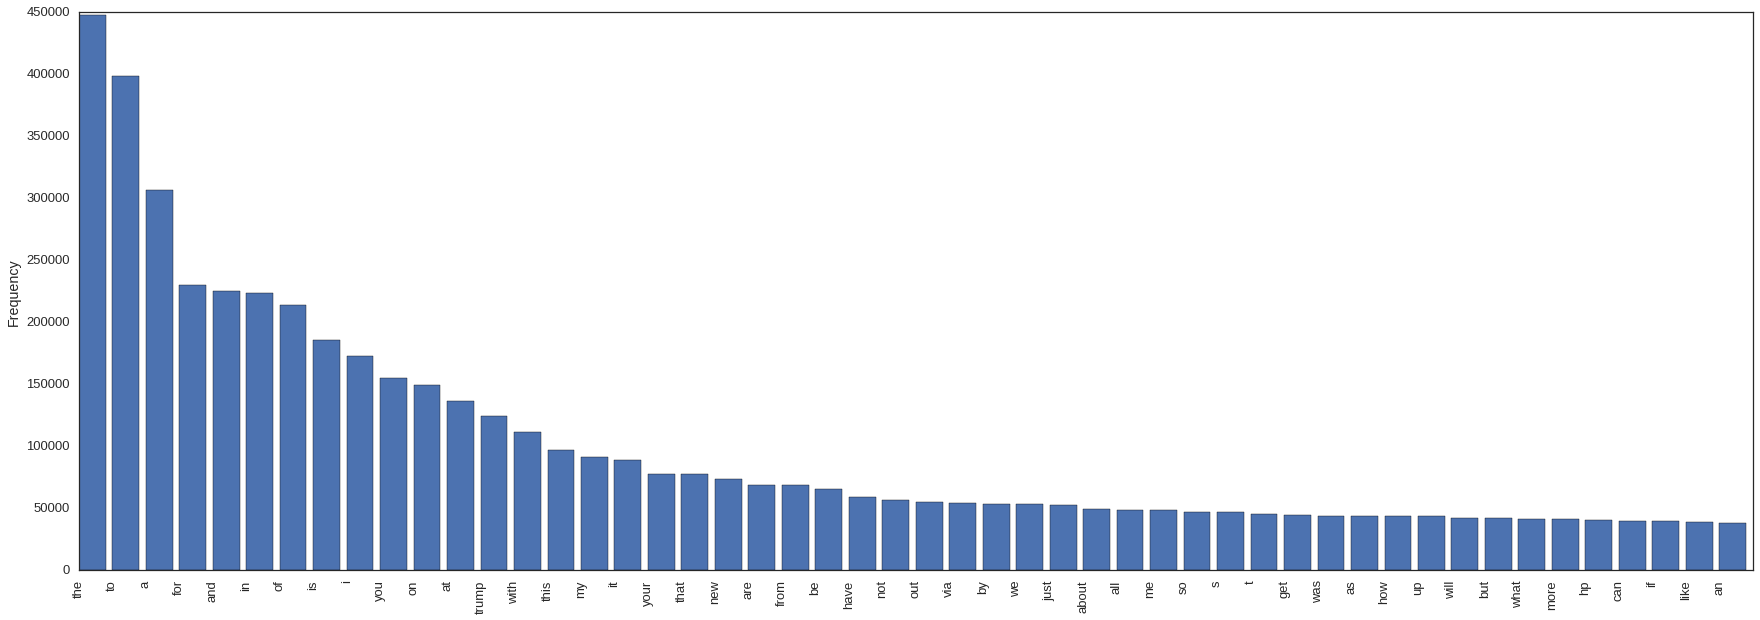

In [21]:
plot_barchart(get_top_50)

In [22]:
get_last_50 = sorted( count_with_stopwords.items() , key=lambda x: x[1] )[:50]
print "Least occuring 50 words"
get_last_50

Least occuring 50 words


[(u'#bigbrowntruck', 1),
 (u'bonced', 1),
 (u'trawling', 1),
 (u'hennings', 1),
 (u'caney', 1),
 (u'quikfix', 1),
 (u'caned', 1),
 (u'fundation', 1),
 (u'canei', 1),
 (u'braga10', 1),
 (u'#thanksforplaying', 1),
 (u'g850w', 1),
 (u'jrpc', 1),
 (u'#tavares', 1),
 (u"fwd'd", 1),
 (u'liquidityweb', 1),
 (u'clnton', 1),
 (u'the#nutrisystem', 1),
 (u'#3dsystems', 1),
 (u'uflood', 1),
 (u'tred', 1),
 (u'videodrome', 1),
 (u'radykalna', 1),
 (u'dayumm', 1),
 (u'#iamnyfw', 1),
 (u'shandling', 1),
 (u'topography', 1),
 (u'#corporatetools', 1),
 (u'#onetoughmothers', 1),
 (u'#vascandal', 1),
 (u'libataire', 1),
 (u"obutthole's", 1),
 (u'#runforthetrees', 1),
 (u'umbuchen', 1),
 (u'dno', 1),
 (u'dnn', 1),
 (u'dnk', 1),
 (u'dnj', 1),
 (u'dnv', 1),
 (u'#kundalini', 1),
 (u'csnchicago', 1),
 (u'#emigration', 1),
 (u'#car#petrolhead', 1),
 (u'iguaz', 1),
 (u'chumpster', 1),
 (u'jumbling', 1),
 (u'#giantsvscard', 1),
 (u'tofigureout', 1),
 (u"fand's", 1),
 (u'#proofmsm', 1)]

In [23]:
################ Total no of words and their percentage

total_word_freq = np.sum(count_with_stopwords.values())
total_unique_word = len(count_with_stopwords)

total_word_count = np.array(count_with_stopwords.values())
word_count = []
word_prob = []
for i in range(1,6):
    print "Total words with frequnecy {}".format(i)
    sub_count = np.where( total_word_count == i)[0]
    print len(sub_count)
    print "Percentage is {}".format(float(len(sub_count)) / total_unique_word)
    print 
    word_count.append(i)
    word_prob.append(float(len(sub_count)) / total_unique_word)
    
word_to_prob = zip(word_count , word_prob)
    

Total words with frequnecy 1
190045
Percentage is 0.531053696376

Total words with frequnecy 2
51591
Percentage is 0.144163704648

Total words with frequnecy 3
22297
Percentage is 0.0623057921445

Total words with frequnecy 4
13814
Percentage is 0.0386012563432

Total words with frequnecy 5
9191
Percentage is 0.0256829410055



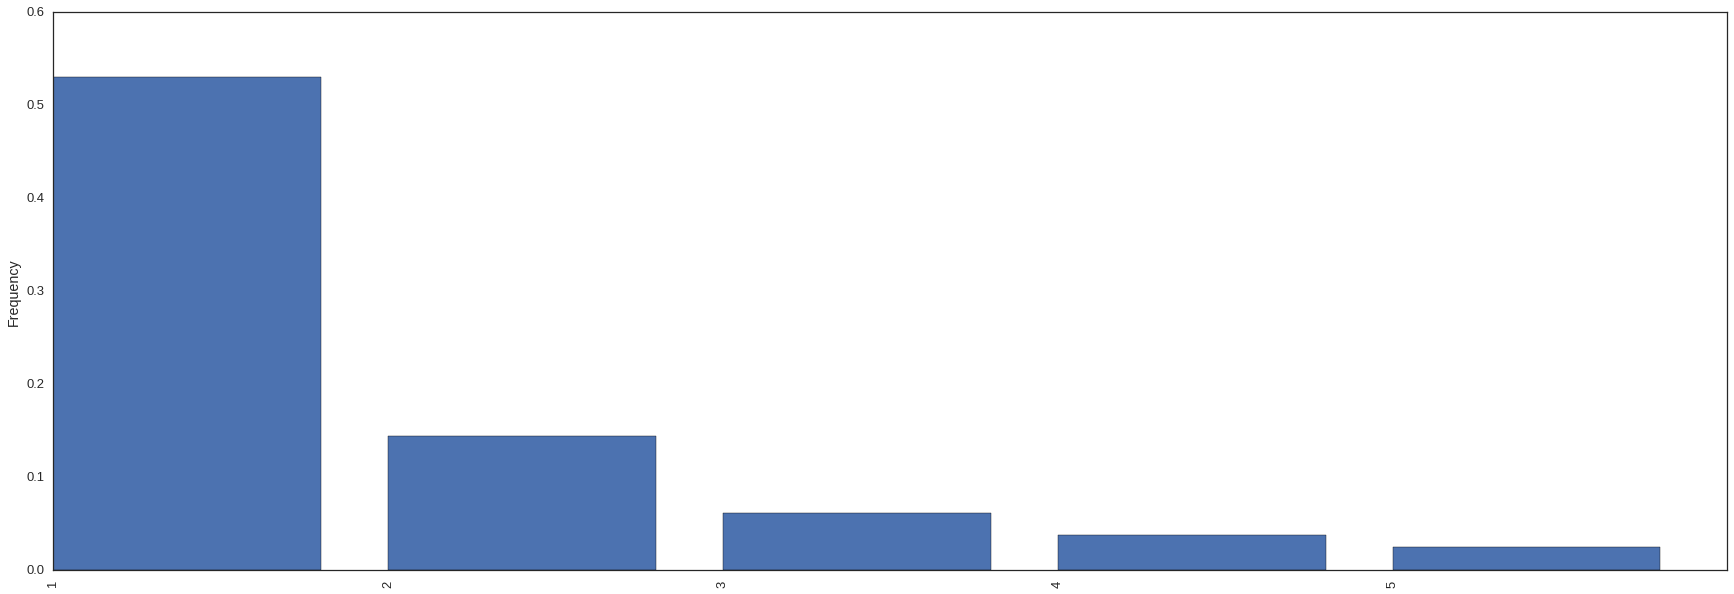

In [24]:
plot_barchart(word_to_prob)

In [25]:
########## Find the length of words

counter_len = {}
for k, v in count_with_stopwords.iteritems():
    counter_len[k] = len(k)
counter_len_max = sorted(counter_len.items() , key=lambda x: x[1] , reverse=True)
counter_len_min = sorted(counter_len.items() , key=lambda x: x[1] )

In [26]:
print "Max length is {}".format(counter_len_max[0])

Max length is (u'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha', 116)


In [27]:
print "Top 50" 
counter_len_max[:131]

Top 50


[(u'hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha',
  116),
 (u'hahahhahahhahahahahahahhahahahahahaahhahahahahahahaahahahhaahhahahahaahahahahahahhahaahhaahhahahahahaahhahahahahaha',
  115),
 (u'#sundaymotivation#lasuiteskincare#bestrong#facials#aesthetician#women#skincare#greenwichct#beauty#girls#men#sunday',
  114),
 (u'#redcarpet#beauty#fashion#skincare#glowingskin#lasuiteskincare#mondaymotivation#lasuiteskincare#greenwichct',
  107),
 (u'xoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxooxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxoxo',
  107),
 (u'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaannnnnnnnnnnnnnnnnnnnnnnnnnnnnnnddddddddddddddddddddddddddddddddddddd',
  105),
 (u'fuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyoufuckyo',
  104),
 (u'#model#mame#fashion#love#nolchashows#newyork#nyc#fashiondesign#city#influence#nyfw#womenswear#jim',
  97),
 (u'#thrivewithm

In [28]:
print "Min length is {}".format(counter_len_min[0])
print "Top 50" 
counter_len_min[:131]

Min length is (u'r', 1)
Top 50


[(u'r', 1),
 (u'd', 1),
 (u'h', 1),
 (u's', 1),
 (u'e', 1),
 (u'9', 1),
 (u't', 1),
 (u'f', 1),
 (u'g', 1),
 (u'7', 1),
 (u'4', 1),
 (u'v', 1),
 (u'0', 1),
 (u'u', 1),
 (u'w', 1),
 (u'i', 1),
 (u'1', 1),
 (u'5', 1),
 (u'j', 1),
 (u'6', 1),
 (u'2', 1),
 (u'y', 1),
 (u'k', 1),
 (u'3', 1),
 (u'z', 1),
 (u'l', 1),
 (u'm', 1),
 (u'n', 1),
 (u'#', 1),
 (u'o', 1),
 (u'a', 1),
 (u'@', 1),
 (u'x', 1),
 (u'p', 1),
 (u'q', 1),
 (u'b', 1),
 (u'\x7f', 1),
 (u'c', 1),
 (u'va', 2),
 (u'vv', 2),
 (u'v2', 2),
 (u'v8', 2),
 (u'hz', 2),
 (u'hj', 2),
 (u'hk', 2),
 (u'hi', 2),
 (u'ho', 2),
 (u'hg', 2),
 (u'aa', 2),
 (u'ac', 2),
 (u'ae', 2),
 (u'ad', 2),
 (u'ag', 2),
 (u'af', 2),
 (u'ai', 2),
 (u'ah', 2),
 (u'aj', 2),
 (u'am', 2),
 (u'al', 2),
 (u'ao', 2),
 (u'an', 2),
 (u'aq', 2),
 (u'ap', 2),
 (u'as', 2),
 (u'ar', 2),
 (u'au', 2),
 (u'aw', 2),
 (u'av', 2),
 (u'ay', 2),
 (u'ax', 2),
 (u'a@', 2),
 (u'a#', 2),
 (u'6m', 2),
 (u'a1', 2),
 (u'a0', 2),
 (u'a3', 2),
 (u'a2', 2),
 (u'a5', 2),
 (u'a4', 2),
 (u'a7',

In [29]:
print "Average length is {}".format(np.mean(counter_len.values()))

Average length is 9.04849887108


In [30]:
################ Total no of words and their percentage

def get_count_stat(counter_data):
    total_word_freq = np.sum(counter_data.values())
    total_unique_word = len(counter_data)

    total_word_count = np.array(counter_data.values())
    word_count = []
    word_prob = []
    for i in range(1,6):
        print "Total words with frequnecy {}".format(i)
        sub_count = np.where( total_word_count == i)[0]
        print len(sub_count)
        print "Percentage is {}".format(float(len(sub_count)) / total_unique_word)
        print 
        word_count.append(i)
        word_prob.append(float(len(sub_count)) / total_unique_word)

    word_to_prob = zip(word_count , word_prob)
    return word_to_prob
    

Total words with frequnecy 1
38
Percentage is 0.000106185590057

Total words with frequnecy 2
1213
Percentage is 0.00338955580891

Total words with frequnecy 3
11458
Percentage is 0.0320177497597

Total words with frequnecy 4
24782
Percentage is 0.0692497708627

Total words with frequnecy 5
35208
Percentage is 0.098383743545



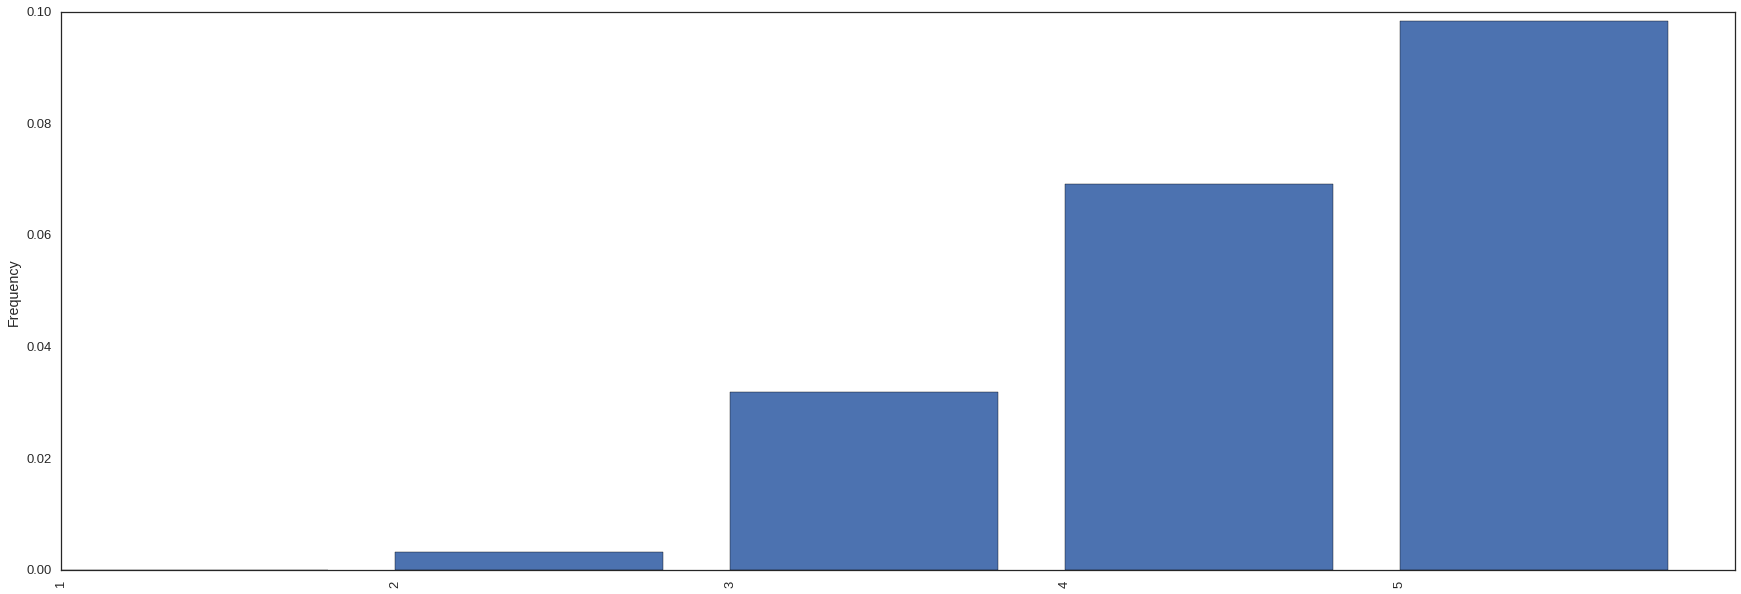

In [31]:
len_stat = get_count_stat(counter_len)
plot_barchart(len_stat)

In [32]:
tweet_list = [tweet.split() for tweet in tweet_parsed if tweet]
print "New tweet length is {}".format(len(tweet_list))
counter_tweet_len = [len(tweet_) for tweet_ in tweet_list]

New tweet length is 1405117


In [33]:
print "Max tweet length {}".format(np.max(counter_tweet_len))
print "Min tweet length {}".format(np.min(counter_tweet_len))
print "Average tweet length {}".format(np.mean(counter_tweet_len))

Max tweet length 41
Min tweet length 0
Average tweet length 13.0581837669


In [34]:
MAX_TWEET_LENGTH = 50 # WORDS
MIN_TWEET_LENGTH = 3

MAX_WORD_LENGTH = 15
MIN_WORD_LENGTH = 4

FREQ_THRESHOLD = 2
def preprocess_tweets(tweet):
    temp_store = []
    
    for word_ in tweet:
        if word_ not in STOPWORDS:
            if len(word_) < MAX_WORD_LENGTH and len(word_) >= MIN_WORD_LENGTH and count_with_stopwords[word_] > 2:
                temp_store.append(word_)
    if len(temp_store) > MIN_TWEET_LENGTH and len(temp_store) <= MAX_TWEET_LENGTH:
        return temp_store

In [35]:
tweet_list = [t.split() for t in tweet_parsed]
%time tweet_preprocess_list = map(preprocess_tweets , tweet_list)

CPU times: user 13min 4s, sys: 3.9 s, total: 13min 8s
Wall time: 12min 15s


In [36]:
######### Remove any null tweets
final_tweets = []
no_tweet_index = []
for i,t in enumerate(tweet_preprocess_list):
    if t:
        final_tweets.append(t)
    else:
        no_tweet_index.append(i)
    

In [38]:
print "No of tweets before preprocessing {} and after preprocessing {} ".format(len(tweet_list) , len(final_tweets))

No of tweets before preprocessing 1405117 and after preprocessing 1229964 


In [39]:
count_with_out_stopwords = get_the_count(text_data=final_tweets , inside_list=True)
get_top_50 = sorted( count_with_out_stopwords.items() , key=lambda x: x[1] , reverse = True)[:50]

In [40]:
get_top_50

[(u'trump', 118943),
 (u'like', 37015),
 (u'hillary', 35943),
 (u'dell', 34084),
 (u'verizon', 31503),
 (u'clinton', 31326),
 (u'#deals', 30496),
 (u'obama', 30365),
 (u"it's", 29106),
 (u'baby', 28891),
 (u'friend', 28406),
 (u'today', 27672),
 (u'week', 26310),
 (u'#nyfw', 25685),
 (u"don't", 24810),
 (u'time', 24235),
 (u'people', 23566),
 (u'donald', 23528),
 (u'fashion', 23473),
 (u'football', 22724),
 (u'deals', 22359),
 (u'best', 22108),
 (u'black', 22014),
 (u'#usa', 21838),
 (u'sprint', 21645),
 (u'great', 21196),
 (u'young', 20776),
 (u'core', 20398),
 (u'good', 20122),
 (u'know', 20095),
 (u'check', 19709),
 (u'#weightloss', 19368),
 (u'free', 19100),
 (u'#smallbiz', 18732),
 (u'want', 18316),
 (u'hunger', 17896),
 (u'love', 17775),
 (u'help', 17439),
 (u'need', 17362),
 (u'airport', 17093),
 (u'mobile', 16787),
 (u'racism', 16705),
 (u'digital', 16418),
 (u'#ebay', 16394),
 (u'#lfw', 16068),
 (u'iphone', 15808),
 (u'video', 15684),
 (u'york', 15634),
 (u'says', 15485),
 (u'

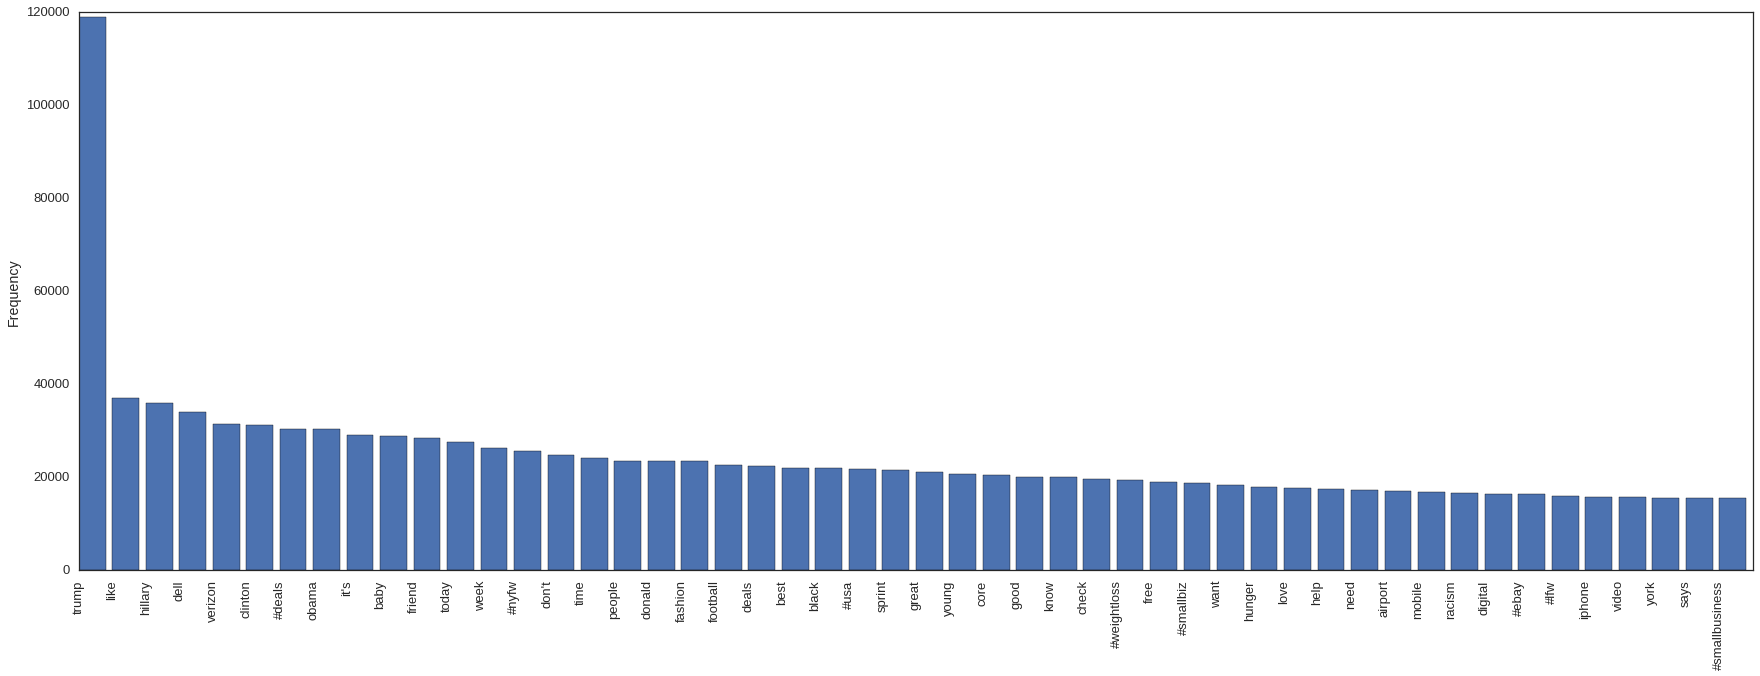

In [41]:
plot_barchart(get_top_50)

In [44]:
get_last_50 = sorted( count_with_out_stopwords.items() , key=lambda x: x[1] )[:50]
print "Least occuring 50 words"
get_last_50

Least occuring 50 words


[(u'raceroom', 1),
 (u'oldu', 1),
 (u'#cellfina', 1),
 (u'#skye', 1),
 (u'photocredit', 1),
 (u'#westlake', 1),
 (u'#campkindle', 1),
 (u'staan', 1),
 (u'#whatyazay', 1),
 (u'#dpweewonder', 1),
 (u'mehrwert', 1),
 (u'#selfietime', 1),
 (u'citradelic', 1),
 (u'flaute', 1),
 (u'#doctory', 1),
 (u'fuuuck', 1),
 (u'malparida', 1),
 (u'gales', 1),
 (u'#imwithamerica', 1),
 (u'#csisdchat', 1),
 (u'adri', 1),
 (u'#flushots', 1),
 (u'voom', 1),
 (u'#vds', 1),
 (u"jeh's", 1),
 (u'#soslow', 1),
 (u'#dontforget', 1),
 (u'oooooo', 1),
 (u'#fuckthepolice', 1),
 (u'#therow', 1),
 (u'phasers', 1),
 (u'tellem', 1),
 (u'carrion', 1),
 (u'feliciap', 1),
 (u'brandys', 1),
 (u'#geauxtigers', 1),
 (u'cravin', 1),
 (u'#defendfreedom', 1),
 (u'niiiiiiice', 1),
 (u'alrededor', 1),
 (u'#damnit', 1),
 (u'karris', 1),
 (u'achin', 1),
 (u'teradatavoice', 1),
 (u'progresso', 1),
 (u'portrayals', 1),
 (u'bellanger', 1),
 (u'cratianam', 1),
 (u'pyschoishps', 1),
 (u'#chanyeol', 1)]

In [45]:
########## Find the length of words

counter_len = {}
for k, v in count_with_out_stopwords.iteritems():
    counter_len[k] = len(k)
counter_len_max = sorted(counter_len.items() , key=lambda x: x[1] , reverse=True)
counter_len_min = sorted(counter_len.items() , key=lambda x: x[1] )
print "Max length is {}".format(counter_len_max[0])
print "Min length is {}".format(counter_len_min[0])

Max length is (u"naeemkhannyc's", 14)
Min length is (u'fawn', 4)


In [46]:
tweet_list = [tweet for tweet in tweet_preprocess_list if tweet]
print "New tweet length is {}".format(len(tweet_list))
counter_tweet_len = [len(tweet_) for tweet_ in tweet_list]
print "Max tweet length {}".format(np.max(counter_tweet_len))
print "Min tweet length {}".format(np.min(counter_tweet_len))
print "Average tweet length {}".format(np.mean(counter_tweet_len))

New tweet length is 1229964
Max tweet length 24
Min tweet length 4
Average tweet length 7.64221635755


In [47]:
# import wiki data
sf_tweet = gl.SFrame(final_tweets)
sf_tweet

This non-commercial license of GraphLab Create for academic use is assigned to sarath@mediaiqdigital.com and will expire on July 06, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1476438467.log


X1
"[checked, #mplaces,donate, mpoints] ..."
"[yass, love, bofa,welcome, home, andy] ..."
"[today's, tell, talking,muslim, american, ..."
"[token, mention,ignoring, history, ..."
"[#trump2016, want,america, safe] ..."
"[wait, thinks, shades,series, worst, thing, ..."
"[#wakeupamerica,#teamtrump, #ccot, #m ..."
"[springen, tier, mensch,blick] ..."
"[trump's, picture, prbly,word, dictionary, trump, ..."
"[#bill, #deplorable,#mcdonalds, favorite, ..."


In [48]:
tweet_docs = gl.text_analytics.count_words(sf_tweet['X1'])

In [49]:
topic_model = gl.topic_model.create(tweet_docs, num_topics=21, num_iterations=200, alpha=5.0)

Learning a topic model

Number of documents   1229964

Vocabulary size    102294

Running collapsed Gibbs sampling

+-----------+---------------+----------------+-----------------+

| Iteration | Elapsed Time  | Tokens/Second  | Est. Perplexity |

+-----------+---------------+----------------+-----------------+

| 10        | 15.04s        | 6.73699e+06    | 0               |

| 20        | 28.84s        | 6.32496e+06    | 0               |

| 30        | 45.54s        | 5.3659e+06     | 0               |

| 40        | 1m 2s         | 5.53361e+06    | 0               |

| 50        | 1m 20s        | 4.61085e+06    | 0               |

| 60        | 1m 39s        | 4.91064e+06    | 0               |

| 70        | 1m 57s        | 5.10276e+06    | 0               |

| 80        | 2m 15s        | 5.17963e+06    | 0               |

| 90        | 2m 32s        | 5.37546e+06    | 0               |

| 100       | 2m 50s        | 5.45012e+06    | 0               |

| 110       | 3m 8s         | 5.11256e+06    | 0               |

| 120       | 3m 25s        | 5.15286e+06    | 0               |

| 130       | 3m 42s        | 5.37239e+06    | 0               |

| 140       | 4m 0s         | 5.50297e+06    | 0               |

| 150       | 4m 17s        | 5.52481e+06    | 0               |

| 160       | 4m 34s        | 5.32621e+06    | 0               |

| 170       | 4m 52s        | 5.18926e+06    | 0               |

| 180       | 5m 9s         | 5.32559e+06    | 0               |

| 190       | 5m 26s        | 5.37977e+06    | 0               |

| 200       | 5m 43s        | 5.33703e+06    | 0               |

+-----------+---------------+----------------+-----------------+

In [50]:
[x['words'] for x in topic_model.get_topics(output_type='topic_words', num_words=10)]

[['#ebay',
  '#usa',
  '#deals',
  '#trump',
  'watch',
  '#maga',
  'live',
  'shopping',
  '#news',
  '#imwithher'],
 ['today',
  'check',
  'case',
  'date',
  'cover',
  '#tcot',
  'checked',
  'download',
  'month',
  'deal'],
 ['#glutenfree',
  'stop',
  'like',
  'people',
  'come',
  'free',
  'walgreens',
  'love',
  'days',
  'store'],
 ['week',
  'fashion',
  'video',
  'york',
  'london',
  'best',
  'times',
  'liked',
  '#paralympics',
  '#rio2016'],
 ['verizon',
  'black',
  'sprint',
  'mobile',
  'deals',
  'iphone',
  'apple',
  'wireless',
  '16gb',
  'samsung'],
 ['trump',
  'obama',
  'college',
  'vote',
  'student',
  'president',
  'voters',
  'america',
  'high',
  'loans'],
 ['#weightloss',
  'young',
  '#health',
  '#diet',
  'weight',
  '#fitness',
  'health',
  'stay',
  'loss',
  'lose'],
 ['#smallbiz',
  '#smallbusiness',
  'learning',
  'business',
  'help',
  'read',
  'small',
  '#entrepreneur',
  'post',
  'online'],
 ['like',
  "it's",
  'good',
  't

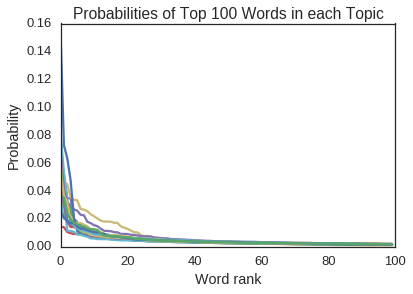

In [51]:
for i in range(20):
    plt.plot(range(100), topic_model.get_topics(topic_ids=[i], num_words=100)['score'])
plt.xlabel('Word rank')
plt.ylabel('Probability')
plt.title('Probabilities of Top 100 Words in each Topic')

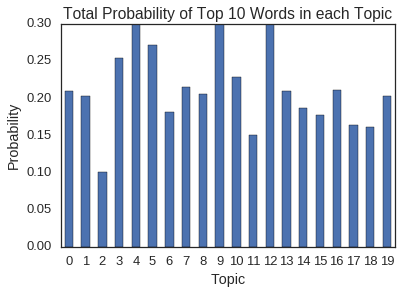

In [83]:
top_probs = [sum(topic_model.get_topics(topic_ids=[i], num_words=10)['score']) for i in range(20)]

ind = np.arange(20)
width = 0.5

fig, ax = plt.subplots()

ax.bar(ind-(width/2),top_probs,width)
ax.set_xticks(ind)

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Total Probability of Top 10 Words in each Topic')
plt.xlim(-0.5,19.5)
plt.ylim(0,0.30)
plt.show()

In [105]:

def average_predictions(model, test_document, n_topics = 21 , num_trials=100):
    avg_preds = np.zeros((model.num_topics))
    for i in range(num_trials):
        avg_preds += model.predict(test_document, output_type='probability')[0]
    avg_preds = avg_preds/num_trials
    result = gl.SFrame({'topics':range(n_topics), 'average predictions':avg_preds})
    result = result.sort('average predictions', ascending=False)
    return result
sample_res =average_predictions(topic_model, gl.SArray([s]), topic_model.num_topics , 100)

sample_res

average predictions,topics
0.047619047619,0
0.047619047619,1
0.047619047619,2
0.047619047619,3
0.047619047619,4
0.047619047619,5
0.047619047619,6
0.047619047619,7
0.047619047619,8
0.047619047619,9


In [104]:
s = {'Was':2 , 'IS':1}

In [97]:
topic_model.get_topics([14],50)

topic,word,score
14,football,0.0483656222664
14,home,0.031390572234
14,game,0.0182913347623
14,team,0.0141216009321
14,family,0.0140645714321
14,play,0.0131608732006
14,card,0.0126454142579
14,million,0.012241820873
14,good,0.0107985358334
14,depot,0.0107831817372


In [98]:
topic_model.show()

Canvas is accessible via web browser at the URL: http://localhost:34318/index.html
Opening Canvas in default web browser.


In [100]:
topic_model.save('../Data/topic_model_v_1.0_gl')